Notebook `code_1-Labelling-Feature-Extraction.ipynb`

- Menerima list file data dan labelnya (0, 1, 2)
- Melakukan labeling pada timestamp yang sesuai
- Melakukan ekstraksi fitur (rms, zcr, dan mfcc)
- Membuat file dataset dengan format pkl yang berisi:
  - nama_file
  - timestamp
  - label
  - raw_audio
  - rms
  - zcr
  - mfcc


Library


In [113]:
import math
import joblib
import numpy as np
from scipy import signal, fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly
import os
import pandas as pd
import json
import pickle
from typing import Tuple, List
from pydub import AudioSegment

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

Konstanta


In [81]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

Dir Folder


In [82]:
dir_data_xc = MAIN_PATH+ r"\Dataset\xeno-canto"
dir_data_nad = MAIN_PATH + r"\Dataset\noise-audio-data"

List File Annotated


In [83]:
labelled_segments_xc = [
    ("19655.mp3", [[1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [5.0, 6.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5]]),
    ("90809.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5]]),
    ("151761.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
    ("193835.mp3", [[1.5, 2.5], [3.0, 4.0], [4.5, 5.5], [7.5, 8.5], [9.5, 10.5], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [18.0, 19.0], [19.5, 20.5], [21.0, 22.0]]),
    ("279210.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0]]),
    ("282469.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [4.5, 5.5], [8.0, 9.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
    ("359523.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [5.0, 6.0], [5.5, 6.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [15.0, 16.0], [16.5, 17.5]]),
    ("359552.mp3", [[0.5, 1.5], [1.0, 2.0], [4.0, 5.0], [4.5, 5.5], [6.0, 7.0], [6.5, 7.5], [8.5, 9.5], [12.0, 13.0], [14.0, 15.0]]),
    ("498380.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5]]),
    ("505545.mp3", [[2.5, 3.5], [4.0, 5.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [22.0, 23.0], [22.5, 23.5]]),
    ("531042.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0]]),
]

labelled_segments_nad = [
    ("1-100032-A-0.wav", [[2.0, 3.0]]),
    ("1-100038-A-14.wav", [[0.0, 1.0]]),
    ("1-100210-A-36.wav", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-100210-B-36.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5]]),
    ("1-101296-A-19.wav", []),
    ("1-101296-B-19.wav", []),
    ("1-101336-A-30.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]),
    ("1-101404-A-34.wav", [[0.0, 1.0]]),
    ("1-103298-A-9.wav", [[0.0, 1.0], [1.5, 2.5], [4.0, 5.0]]),
    ("1-103995-A-30.wav", [[0.0, 1.0]]),
    ("1-103999-A-30.wav", [[0.0, 1.0]]),
    ("1-104089-A-22.wav", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-104089-B-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-105224-A-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-110389-A-0.wav", [[0.0, 1.0]]),
    ("1-110537-A-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-115521-A-19.wav", [[0.0, 1.0], [3.5, 4.5]]),
    ("1-115545-A-48.wav", []),
    ("1-115545-B-48.wav", [[0.0, 1.0]]),
    ("1-115545-C-48.wav", [[0.5, 1.5]]),
    ("1-115546-A-48.wav", [[0.5, 1.5]]),
    ("1-115920-B-22.wav", []),
    ("1-115921-A-22.wav", []),
    ("1-116765-A-41.wav", [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-11687-A-47.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5]]),
    ("1-118206-A-31.wav", []),
    ("1-118559-A-17.wav", []),
    ("1-121951-A-8.wav", []),
    ("1-13571-A-46.wav", [[0.0, 1.0], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-13572-A-46.wav", [[2.0, 3.0]]),
    ("1-13613-A-37.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-137-A-32.wav", []),
    ("1-977-A-39.wav", [[0.0, 1.0]]),
    ("1-1791-A-26.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0]]),
    ("1-7974-A-49.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-7974-B-49.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0]]),
]

labeled_file_name = [
    "19655.mp3",
    "90809.mp3",
    "151761.mp3",
    "193835.mp3",
    "279210.mp3",
    "282469.mp3",
    "359523.mp3",
    "359552.mp3",
    "498380.mp3",
    "505545.mp3",
    "531042.mp3",
    "1-100032-A-0.wav",
    "1-100038-A-14.wav",
    "1-100210-A-36.wav",
    "1-100210-B-36.wav",
    "1-101296-A-19.wav",
    "1-101296-B-19.wav",
    "1-101336-A-30.wav",
    "1-101404-A-34.wav",
    "1-103298-A-9.wav",
    "1-103995-A-30.wav",
    "1-103999-A-30.wav",
    "1-104089-A-22.wav",
    "1-104089-B-22.wav",
    "1-105224-A-22.wav",
    "1-110389-A-0.wav",
    "1-110537-A-22.wav",
    "1-115521-A-19.wav",
    "1-115545-A-48.wav",
    "1-115545-B-48.wav",
    "1-115545-C-48.wav",
    "1-115546-A-48.wav",
    "1-115920-B-22.wav",
    "1-115921-A-22.wav",
    "1-116765-A-41.wav",
    "1-11687-A-47.wav",
    "1-118206-A-31.wav",
    "1-118559-A-17.wav",
    "1-121951-A-8.wav",
    "1-13571-A-46.wav",
    "1-13572-A-46.wav",
    "1-13613-A-37.wav",
    "1-137-A-32.wav",
    "1-977-A-39.wav",
    "1-1791-A-26.wav",
    "1-7974-A-49.wav",
    "1-7974-B-49.wav",
]

labelled_list = labelled_segments_xc + labelled_segments_nad

# Pra-Pemrosesan


Function


In [84]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    """Load audio file using librosa (automatically resamples to target SR if needed)"""
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    """Convert to mono by averaging channels if multichannel"""
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    """Resample audio to target sample rate using librosa (higher quality)"""
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    """Pad audio to make length a multiple of SEGMENT_DURATION"""
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    """Split audio into overlapping segments using numpy"""
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

Function Utama


In [85]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

# Ekstraksi Fitur


Function


In [86]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_zcr(segment):
    return np.mean(librosa.feature.zero_crossing_rate(y=segment))

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

## Durasi


Function


In [87]:
def hitung_durasi_file_ada(folder_path, daftar_nama_file):
    total_durasi = 0
    file_ada = []

    file_di_folder = set(os.listdir(folder_path))

    for nama_file in daftar_nama_file:
        if nama_file in file_di_folder:
            file_path = os.path.join(folder_path, nama_file)
            try:
                audio = AudioSegment.from_file(file_path)
                total_durasi += len(audio)
                file_ada.append(nama_file)
            except Exception as e:
                print(f"Gagal membaca {nama_file}: {e}")

    total_durasi_detik = total_durasi / 1000
    return total_durasi_detik, file_ada

Running


In [88]:
# durasi_nad, file_ditemukan_nad = hitung_durasi_file_ada(dir_data_nad, labeled_file_name)
# durasi_xc, file_ditemukan_xc = hitung_durasi_file_ada(dir_data_xc, labeled_file_name)

# print(f"Total durasi file xeno canto: {durasi_xc // 60} menit {durasi_xc % 60} detik")
# print(f"Total durasi file nad: {durasi_nad // 60} menit {durasi_nad % 60} detik")
# print(f"Total durasi seluruhnya: {(durasi_xc + durasi_nad) // 60} menit {(durasi_xc + durasi_nad) % 60} detik")
# print(f"train durasi: {((durasi_xc + durasi_nad)*80/100) // 60} menit {((durasi_xc + durasi_nad)*80/100) % 60} detik")
# print(f"val durasi: {((durasi_xc + durasi_nad)*10/100) // 60} menit {((durasi_xc + durasi_nad)*80/100) % 60}  detik")
# print(f"test durasi: {((durasi_xc + durasi_nad)*10/100) // 60} menit {((durasi_xc + durasi_nad)*80/100) % 60} detik")

# Visualize


Function


In [89]:
def load_and_plot(path, list_result, final_time):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

    plt.xticks(np.arange(0, final_time, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, final_time)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [90]:
# for data in labelled_segments_nad:
#     load_and_plot(os.path.join(dir_data_nad, data[0]), data[1], 5.1)

In [91]:
# for data in labelled_segments_xc:
#     load_and_plot(os.path.join(dir_data_xc, data[0]), data[1], 25.1)

# Labeling Timestamp


Helper


In [92]:
def generate_timestamps(duration):
    list_timestamp = []

    for i in np.arange(0, duration-0.5, 0.5):
        list_timestamp.append([i, i+1.0])

    return list_timestamp

def labeling_list(audio_path, list_label, label_dataset):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    list_timestamp = generate_timestamps(len(audio) / SAMPLE_RATE)

    list_timestamp_label = []
    for timestamp in list_timestamp:
        if timestamp in list_label:
            list_timestamp_label.append((audio_path, timestamp, label_dataset))
        else:
            list_timestamp_label.append((audio_path, timestamp, 2))

    return list_timestamp_label

Generate List Labelled Timestamp


In [93]:
list_timestamp_label_xc = []
for file in labelled_segments_xc:
    list_timestamp_label_xc += labeling_list(os.path.join(dir_data_xc, file[0]), file[1], 0)

list_timestamp_label_nad = []
for file in labelled_segments_nad:
    list_timestamp_label_nad += labeling_list(os.path.join(dir_data_nad, file[0]), file[1], 1)
    
dataset_labelled = list_timestamp_label_xc + list_timestamp_label_nad

In [96]:
# dataset_labelled[0]

('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
 [0.0, 1.0],
 2)

# Extract Features


Generete fitur tiap segment


In [97]:
dataset_fe = []

for data in dataset_labelled:
    segments = prapemrosesan(data[0])
    index = int(data[1][0] / 0.5)
    segment = segments[index]
    rms = get_rms(segment)
    zcr = get_zcr(segment)
    mfcc = get_mfcc(segment)

    data = {
        "nama": data[0],
        "timestamp": data[1],
        "label": data[2],
        "raw": segment,
        "rms": rms,
        "zcr": zcr,
        "mfcc": mfcc,
    }

    dataset_fe += [data]

In [98]:
dataset_fe

[{'nama': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'timestamp': [0.0, 1.0],
  'label': 2,
  'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
          1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
  'rms': 0.011059444,
  'zcr': 0.23255173703457446,
  'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
          -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
         [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
          -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
         [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
          -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
           7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
         [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
           5.2022276e+00,  3.3751645e+00, -6.7336679e+00],
         [

In [99]:
df = pd.DataFrame(dataset_fe, columns=["nama", "timestamp", "label", "raw", "rms", "zcr", "mfcc"])

In [100]:
df

,nama,timestamp,label,raw,rms,zcr,mfcc
0,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[0.0, 1.0]",2,"[-6.6490856e-13, -2.050342e-13, 1.972623e-12, ...",0.011059,0.232552,"[[-927.0955, -927.0955, -866.9258, -798.5749, ..."
1,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[0.5, 1.5]",2,"[0.006999825, -0.0023220887, -0.009327633, -0....",0.023861,0.232910,"[[-481.9903, -491.30905, -525.08264, -521.4715..."
2,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[1.0, 2.0]",2,"[0.007474064, -0.0023474745, -0.015351549, -0....",0.054715,0.242795,"[[-402.2729, -402.03827, -422.76993, -422.2318..."
3,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[1.5, 2.5]",0,"[-0.014644066, 0.022145856, 0.039345846, 0.032...",0.083691,0.245294,"[[-354.79245, -365.84024, -397.24753, -393.230..."
4,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[2.0, 3.0]",0,"[-0.0077111307, -0.054820124, -0.05797666, -0....",0.088785,0.243746,"[[-340.9444, -352.2099, -390.10266, -391.06473..."
...,...,...,...,...,...,...,...
860,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[3.0, 4.0]",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37..."
861,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[3.5, 4.5]",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37..."
862,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[4.0, 5.0]",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37..."
863,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[4.5, 5.5]",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37..."


Save


In [102]:
with open(f"{MAIN_PATH}/Dataset/dataset.pkl", "wb") as f:
    pickle.dump(dataset_fe, f)

# Visualize Labels


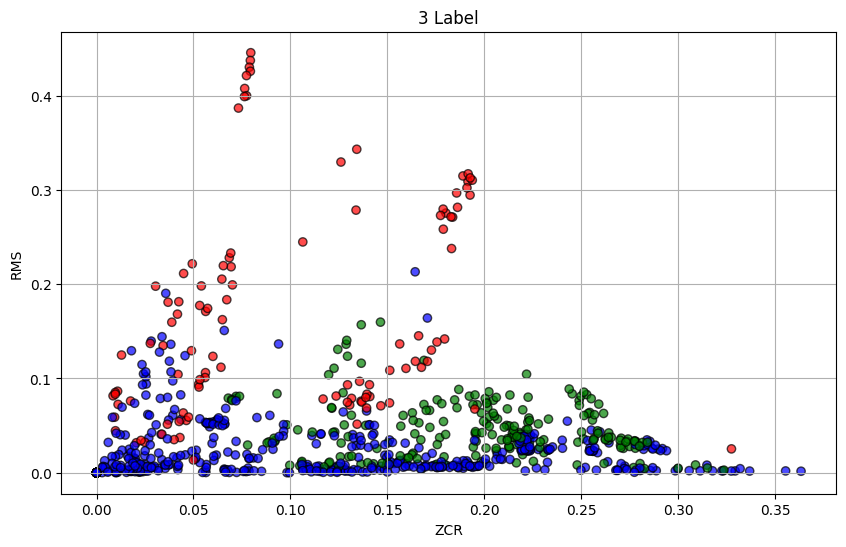

In [106]:
colors = df['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df['zcr'], df['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.grid(True)
plt.title("3 Label")
plt.show()

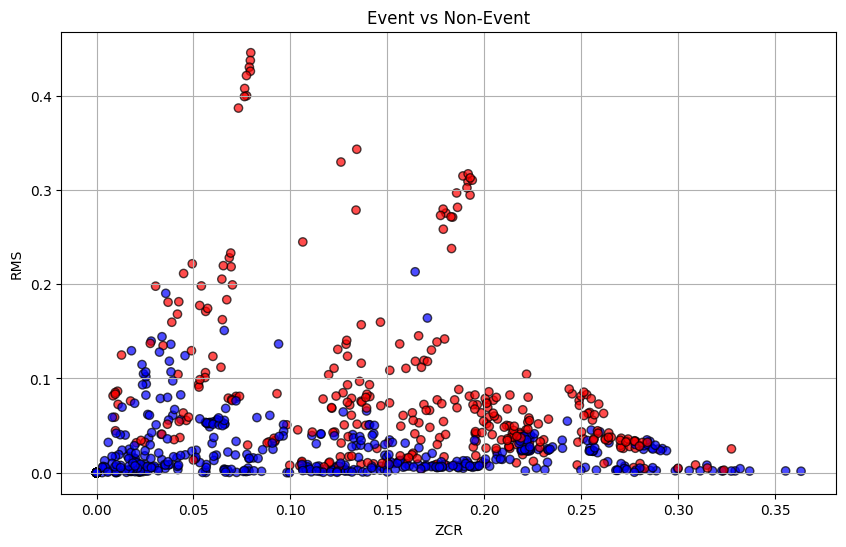

In [107]:
colors = df['label'].map({2: 'blue', 1: 'red', 0:'red'})
plt.figure(figsize=(10, 6))
plt.scatter(df['zcr'], df['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.grid(True)
plt.title("Event vs Non-Event")
plt.show()

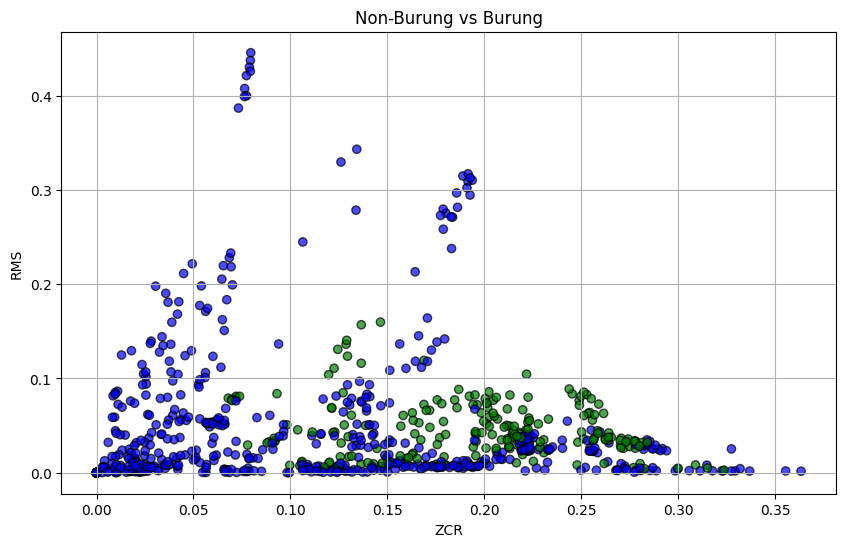

In [108]:
colors = df['label'].map({2: 'blue', 1: 'blue', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df['zcr'], df['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.grid(True)
plt.title("Non-Burung vs Burung")
plt.show()

In [109]:
df_0 = df[df["label"] == 0]
df_1 = df[df["label"] == 1]
df_2 = df[df["label"] == 2]

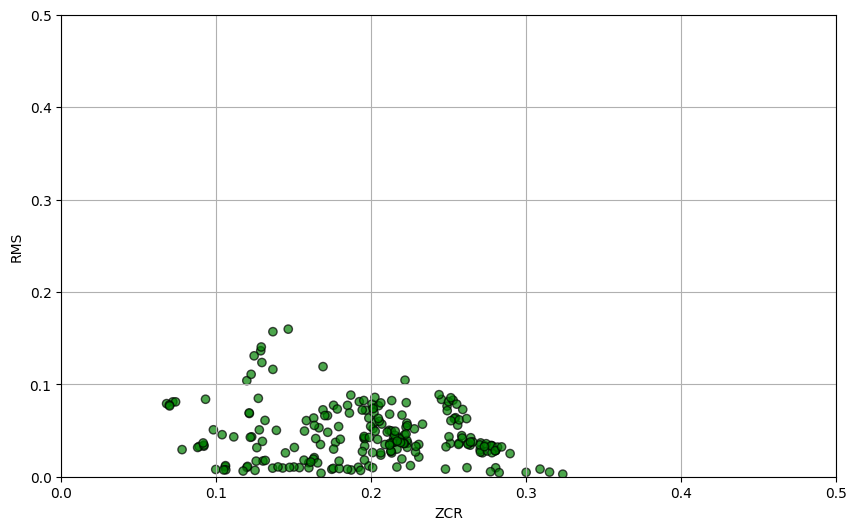

In [110]:
colors = df_0['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_0['zcr'], df_0['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

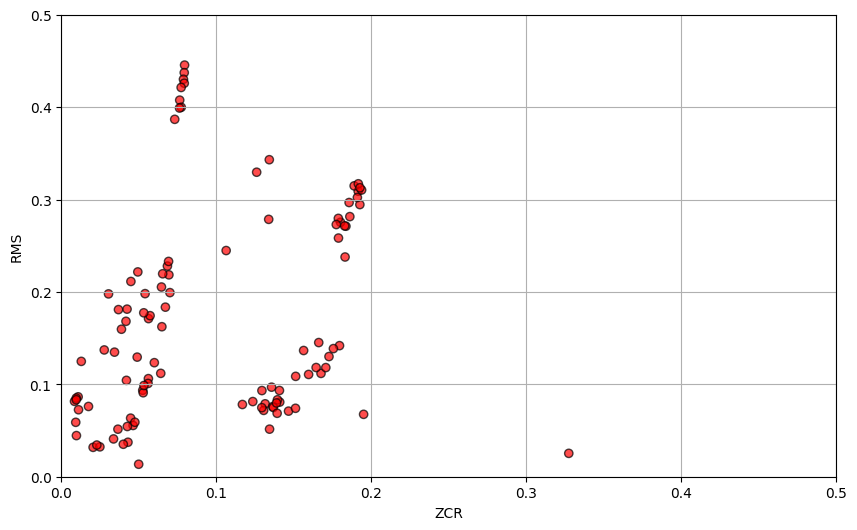

In [111]:
colors = df_1['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_1['zcr'], df_1['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

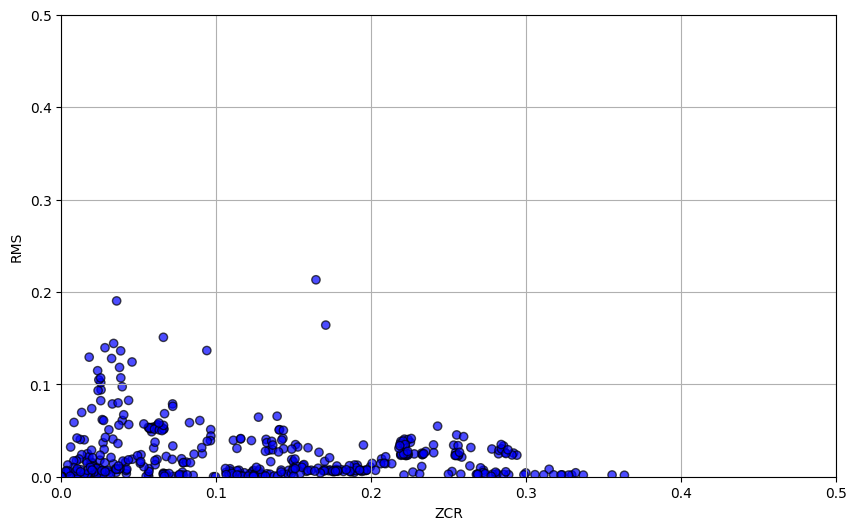

In [112]:
colors = df_2['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_2['zcr'], df_2['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

# Logistic Regression testing


In [114]:
dataset_fe

[{'nama': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'timestamp': [0.0, 1.0],
  'label': 2,
  'raw': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
          1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32),
  'rms': 0.011059444,
  'zcr': 0.23255173703457446,
  'mfcc': array([[-9.2709552e+02, -9.2709552e+02, -8.6692578e+02, ...,
          -4.9831238e+02, -4.7504291e+02, -3.9764847e+02],
         [ 0.0000000e+00,  0.0000000e+00, -1.4798780e+01, ...,
          -8.1901199e+01, -5.0254303e+01,  2.3999417e+00],
         [ 0.0000000e+00,  0.0000000e+00, -5.1890976e+01, ...,
          -2.6562943e+02, -2.3930214e+02, -1.4375620e+02],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  8.7950077e+00, ...,
           7.3784947e-01,  1.3385715e+00,  2.1685948e+00],
         [ 0.0000000e+00,  0.0000000e+00, -1.2696293e+01, ...,
           5.2022276e+00,  3.3751645e+00, -6.7336679e+00],
         [

In [115]:
X = [(data["rms"], data["zcr"]) for data in dataset_fe]
y = [data["label"] for data in dataset_fe]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.6936416184971098


array([[22,  1, 21],
       [ 6, 12,  4],
       [20,  1, 86]], dtype=int64)

In [119]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    color_map = {0: 'green', 1: 'red', 2: 'blue'}
    colors = [color_map[label] for label in y]
    
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')

    legend_elements = [
        Patch(facecolor='green', edgecolor='k', label='Suara Burung'),
        Patch(facecolor='Red', edgecolor='k', label='Suara Event Non-Burung'),
        Patch(facecolor='Blue', edgecolor='k', label='Suara Non-Event')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("RMS")
    plt.ylabel("ZCR")
    plt.title("Fitur RMS dan ZCR dengan Label")
    plt.show()

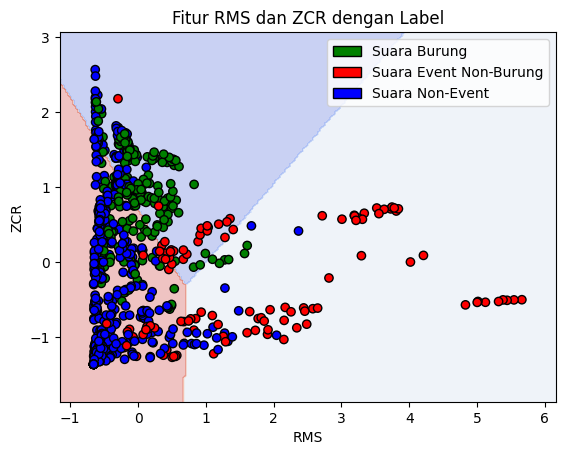

In [120]:
X_scaled = scaler.transform(X)
plot_decision_boundary(model, X_scaled, y)

In [130]:
X = [(data["rms"], data["zcr"]) for data in dataset_fe]
y_original = [data["label"] for data in dataset_fe]
y = [1 if label == 0 or label == 1 else 0 for label in y_original]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.8265895953757225


array([[97, 10],
       [20, 46]], dtype=int64)

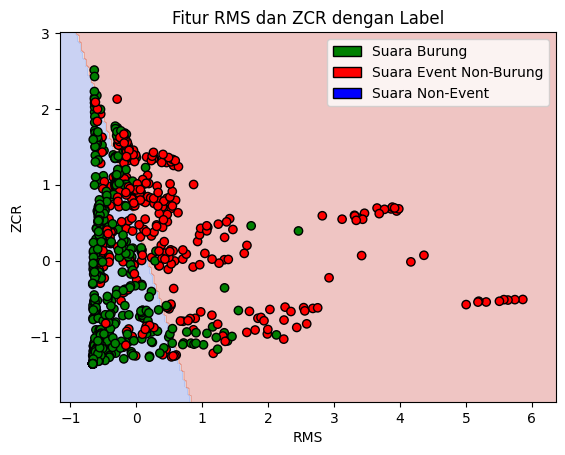

In [132]:
X_scaled = scaler.transform(X)
plot_decision_boundary(model, X_scaled, y)

In [133]:
print("Coefficients (weights) per class:")
print(model.coef_)

print("\nIntercepts (bias) per class:")
print(model.intercept_)

Coefficients (weights) per class:
[[2.42586353 0.86888415]]

Intercepts (bias) per class:
[-0.40963092]
